In [2]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
cos = nn.CosineSimilarity(dim=0, eps=1e-9)
from torchvision import transforms
# to get the relationship between TopK parameters and the attack success rate

In [3]:
from models import ConvNet
from utils import *
from torch.utils.data import DataLoader

In [5]:
# Define transformation (convert images to tensors and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image with mean and std
])

# Load the training dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Load the test dataset
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batch processing
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
client_loaders, test_loader, client_data_subsets = data.get_loaders(train_data, test_data, n_clients=100,
                                                                        alpha=1.0, batch_size=32, n_data=None, num_workers=4, seed=4)

Data split:
 - Client 0: [226  18  19  79  27 116  25   3  35  47]               -> sum=595
 - Client 1: [ 86  54   6  41   2  98 160 128   4  20]               -> sum=599
 - Client 2: [150  21  89  25   3  55  60 178   2  19]               -> sum=602
 - Client 3: [ 59 103  22 131 163   9  28  29   2  53]               -> sum=599
 - Client 4: [ 61 185  28  97  35  54  23   9   2 106]               -> sum=600
 - Client 5: [ 17  64  24  20  10 229 121  28  24  63]               -> sum=600
 - Client 6: [232   5   9  30   7 123   7  20  93  75]               -> sum=601
 - Client 7: [  0  71  38  46  45  74   1  81 155  87]               -> sum=598
 - Client 8: [ 22  79  22   9  83 138  50  82  37  79]               -> sum=601
 - Client 9: [29 83 47 76 98 26 25 55 72 89]                         -> sum=600
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
 - Client 91: [ 18  44  49  84  21  49 141  47  83  62]               -> sum=598
 - Client 92: 

In [11]:
client_loader = client_loaders[4]

In [8]:
device = "cuda"

In [9]:
model1 = ConvNet(im_size = (28,28), dataset = 'fmnist').to(device)
model2 = ConvNet(im_size = (28,28), dataset = 'fmnist').to(device)
model0 = {k: v.clone().detach() for k, v in model1.state_dict().items()}
model2.load_state_dict(model1.state_dict())

num feat 2048
num feat 2048


<All keys matched successfully>

In [10]:
optimizer1 = optim.SGD(model1.parameters(), lr=0.001)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001)

In [12]:
# train with benign dataset

train_op(model1, client_loader, optimizer1, epochs=1, print_train_loss=True)

[2.41, 2.22, 2.03, 1.9, 1.81, 1.74, 1.67, 1.62, 1.57, 1.52]


{'loss': 1.8443848101298015}

In [13]:
train_op_tr_flip(model2, client_loader, optimizer2, epochs=1, class_num=10, print_train_loss=True)

[2.31, 1.98, 1.75, 1.81, 1.82, 1.72, 1.65, 1.74, 1.56, 1.36]


{'loss': 1.7791100804011026}

# Evaluate the model after training

In [14]:
# test the main task

eval_op_ensemble([model1], test_loader)

{'test_accuracy': 0.2027}

In [15]:
eval_op_ensemble([model2], test_loader)

{'test_accuracy': 0.2605}

In [16]:
# test the attack success rate

eval_op_ensemble_tr_lf_attack([model1], test_loader).items()

dict_items([('accuracy', 0.0)])

In [17]:
eval_op_ensemble_tr_lf_attack([model2], test_loader).items()

dict_items([('accuracy', 0.408)])

In [15]:
# model1

In [18]:
# cos between trained models
flat_model0 = flat_dict_grad(model0)
flat_model1 = flat_dict_grad(model1.state_dict())
flat_model2 = flat_dict_grad(model2.state_dict())

In [19]:
flat_model1 - flat_model0

tensor([ 1.6972e-04,  7.0453e-05, -1.5795e-05,  ..., -8.3963e-04,
        -1.3404e-03,  1.6219e-03], device='cuda:0')

In [20]:
cos = nn.CosineSimilarity(dim=0, eps=1e-11)
cos((flat_model1 - flat_model0), (flat_model2 - flat_model0))

tensor(0.8966, device='cuda:0')

In [21]:
# analyzing critical parameters
# Towards Attack-tolerant Federated Learning via Critical Parameter Analysis
# use self-defined method to try

abs_delta = torch.abs(flat_model2 - flat_model1)

In [22]:
abs_delta

tensor([7.0214e-05, 1.5914e-05, 6.5267e-06,  ..., 1.1120e-06, 2.0420e-05,
        2.1106e-05], device='cuda:0')

In [23]:
data_np = abs_delta.cpu().detach().numpy()

In [24]:
data_np

array([7.0214272e-05, 1.5914440e-05, 6.5267086e-06, ..., 1.1119992e-06,
       2.0420179e-05, 2.1105632e-05], dtype=float32)

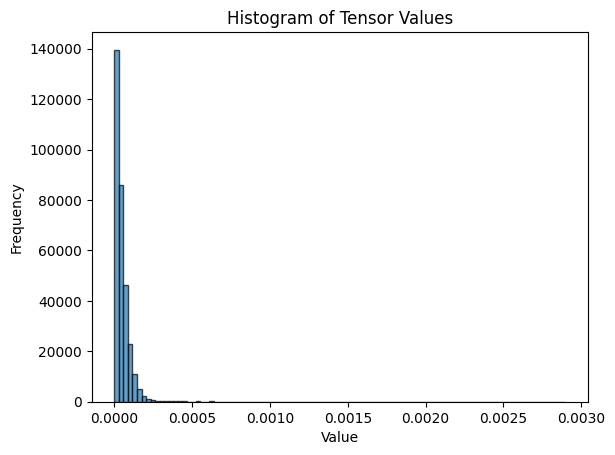

In [25]:

# data = torch.tensor([1, 1, 2, 1])

# Convert tensor to NumPy for plotting


# Plot histogram
plt.hist(data_np, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Tensor Values")
plt.show()

In [26]:
def replace_top_r_percent(a, b, c, k):
    n = b.numel()
    top_k = max(1, int(n * (k / 100)))  # Ensure at least one element is selected
    threshold = torch.topk(b, top_k, sorted=True).values[-1]  # Get the r%-th largest value

    mask = b >= threshold  # Mask for top r% values
    result = torch.where(mask, c, a)  # Replace selected positions in a with c

    return result

# Example usage
a = torch.tensor([1, 3, -5, 1])
b = torch.tensor([0, 0, 2, 0])
c = torch.tensor([4, 3, 7, 6])

r = 25  # Top 25% replacement
output = replace_top_r_percent(a, b, c, r)
print(output)  # Expected: tensor([1, 3, 7, 1])



tensor([1, 3, 7, 1])


In [ ]:
# try combined model's cos and attack success rate

In [27]:
crafted_model = replace_top_r_percent(flat_model1, abs_delta, flat_model2, k=0.25)

In [28]:
crafted_model

tensor([ 0.1915,  0.2580,  0.1741,  ..., -0.0204,  0.0177,  0.0117],
       device='cuda:0')

In [29]:
cos((flat_model1 - flat_model0), (crafted_model - flat_model0))

tensor(0.9566, device='cuda:0')

In [30]:
# restore the weights back to the model to test attack success rate
def restore_dict_grad(flat_grad, model_dict):
    restored_grad = {}
    start = 0
    for name, param in model_dict.items():
        num_elements = param.numel()
        restored_grad[name] = flat_grad[start:start + num_elements].view(param.shape)
        start += num_elements
    return restored_grad

In [31]:
restored_crafted = restore_dict_grad(crafted_model, model2.state_dict())

In [32]:
model2.load_state_dict(restored_crafted )

<All keys matched successfully>

In [34]:
eval_op_ensemble([model2], test_loader)

{'test_accuracy': 0.2034}

In [35]:
eval_op_ensemble_tr_lf_attack([model2], test_loader).items()

dict_items([('accuracy', 0.002)])

In [1]:
list(range(0, 101,5))

[0,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100]

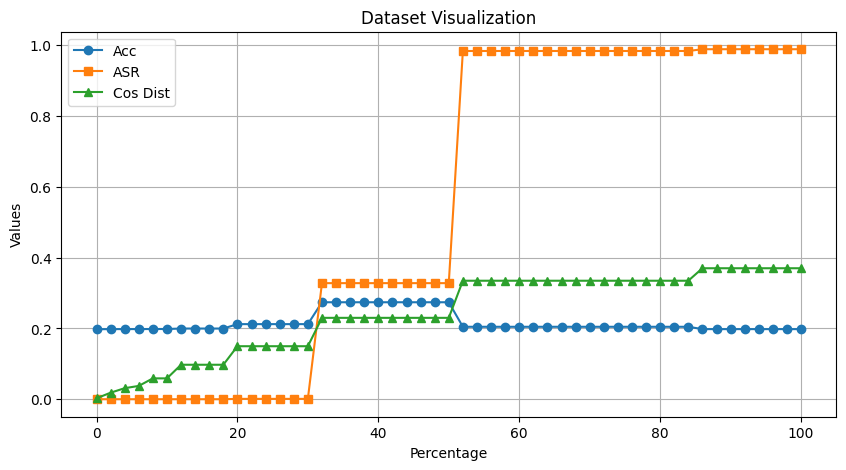

In [5]:
import matplotlib.pyplot as plt

# Data
data = {
 0: (0.1978, 0.0, 0.002549290657043457),
 2: (0.1981, 0.0, 0.01845616102218628),
 4: (0.1982, 0.0, 0.031197071075439453),
 6: (0.1982, 0.0, 0.037589848041534424),
 8: (0.1984, 0.0, 0.05892503261566162),
 10: (0.1984, 0.0, 0.05892503261566162),
 12: (0.1997, 0.0, 0.09739971160888672),
 14: (0.1997, 0.0, 0.09739971160888672),
 16: (0.1997, 0.0, 0.09739971160888672),
 18: (0.1997, 0.0, 0.09739971160888672),
 20: (0.2122, 0.001, 0.14976048469543457),
 22: (0.2122, 0.001, 0.14976048469543457),
 24: (0.2122, 0.001, 0.14976048469543457),
 26: (0.2122, 0.001, 0.14976048469543457),
 28: (0.2122, 0.001, 0.14976048469543457),
 30: (0.2122, 0.001, 0.14976048469543457),
 32: (0.274, 0.328, 0.2299501895904541),
 34: (0.274, 0.328, 0.2299501895904541),
 36: (0.274, 0.328, 0.2299501895904541),
 38: (0.274, 0.328, 0.2299501895904541),
 40: (0.274, 0.328, 0.2299501895904541),
 42: (0.274, 0.328, 0.2299501895904541),
 44: (0.274, 0.328, 0.2299501895904541),
 46: (0.274, 0.328, 0.2299501895904541),
 48: (0.274, 0.328, 0.2299501895904541),
 50: (0.274, 0.328, 0.2299501895904541),
 52: (0.2047, 0.984, 0.33482885360717773),
 54: (0.2047, 0.984, 0.33482885360717773),
 56: (0.2047, 0.984, 0.33482885360717773),
 58: (0.2047, 0.984, 0.33482885360717773),
 60: (0.2047, 0.984, 0.33482885360717773),
 62: (0.2047, 0.984, 0.33482885360717773),
 64: (0.2047, 0.984, 0.33482885360717773),
 66: (0.2047, 0.984, 0.33482885360717773),
 68: (0.2047, 0.984, 0.33482885360717773),
 70: (0.2047, 0.984, 0.33482885360717773),
 72: (0.2047, 0.984, 0.33482885360717773),
 74: (0.2047, 0.984, 0.33482885360717773),
 76: (0.2047, 0.984, 0.33482885360717773),
 78: (0.2047, 0.984, 0.33482885360717773),
 80: (0.2047, 0.984, 0.33482885360717773),
 82: (0.2047, 0.984, 0.33482885360717773),
 84: (0.2047, 0.984, 0.33482885360717773),
 86: (0.1981, 0.989, 0.3701061010360718),
 88: (0.1981, 0.989, 0.3701061010360718),
 90: (0.1981, 0.989, 0.3701061010360718),
 92: (0.1981, 0.989, 0.3701061010360718),
 94: (0.1981, 0.989, 0.3701061010360718),
 96: (0.1981, 0.989, 0.3701061010360718),
 98: (0.1981, 0.989, 0.3701061010360718),
 100: (0.1981, 0.989, 0.3701061010360718)}


keys = list(data.keys())
acc = [v[0] for v in data.values()]
asr = [v[1] for v in data.values()]
cos_dist = [v[2] for v in data.values()]

plt.figure(figsize=(10, 5))
plt.plot(keys, acc, label='Acc', marker='o')
plt.plot(keys, asr, label='ASR', marker='s')
plt.plot(keys, cos_dist, label='Cos Dist', marker='^')

plt.xlabel('Percentage')
plt.ylabel('Values')
plt.title('Dataset Visualization')
plt.legend()
plt.grid()
plt.show()
